In [8]:
import pickle
import csv

import glob2
import numpy as np
from matplotlib import pyplot as plt
from sklearn import metrics

from utils.eval.eval_utils import compute_ROC

In [21]:
ROOT_DIR = "/media/plerolland/LaBoite/PublicData/test/HYDROMOMAR_2013/scalograms20s"
ROOT_DIR = "/media/plerolland/LaBoite/PublicData/test/OHASISBIO_2020/scalograms20s"
CHECKPOINT = "/media/plerolland/LaBoite/PublicData/trainings/SGBT/save_model_100s"
OUTPUT_FILES_SUFFIX = "sgbt20_oha2020"

In [22]:
with open(ROOT_DIR + "/dataset.csv", "r") as f:
    csv_reader = csv.reader(f, delimiter=",")
    lines = list(csv_reader)

pos_f = glob2.glob(f"{ROOT_DIR}/positives/*.npy")
pos_data = {p.split("/")[-1]:np.load(p) for p in pos_f}
neg_f = glob2.glob(f"{ROOT_DIR}/negatives/*.npy")
neg_data = {n.split("/")[-1]:np.load(n) for n in neg_f}

posX, negX = [], []
for line in lines:
    _X_list = posX if line[2]=="positive" else negX
    data = pos_data if line[2]=="positive" else neg_data
    station = line[0].split("/")[-1]
    idx = int(line[1])
    _X_list.append(data[station][idx])
posX, negX = np.array(posX), np.array(negX)
posY, negY = np.ones(len(posX)), np.zeros(len(negX))
X = np.concatenate((posX, negX))
Y = np.concatenate((posY, negY))
print(f"{len(posX)} positive samples and {len(negX)} negative samples found")

2927 positive samples and 28177 negative samples found


In [23]:
with open(CHECKPOINT, 'rb') as f:
    model = pickle.load(f)

In [24]:
pred = model.predict_proba(X)[:,1]
print(metrics.roc_auc_score(Y, pred))

0.5975205979566016


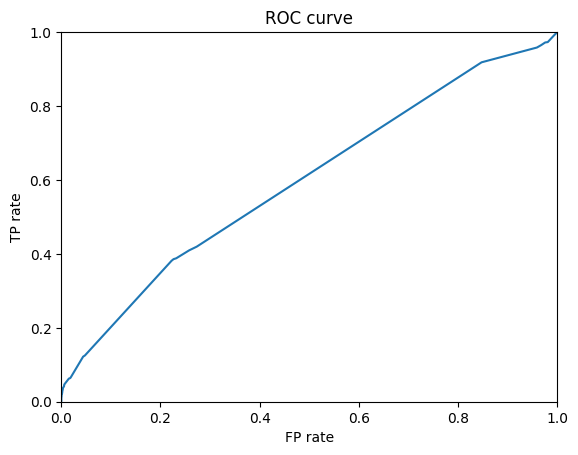

In [25]:
TPr, FPr = compute_ROC(pred[Y==1], np.count_nonzero(Y==1), pred[Y==0], np.count_nonzero(Y==0), thresh_delta=0.001)
plt.plot(FPr, TPr)
np.save(f"data/FPr_{OUTPUT_FILES_SUFFIX}.npy", FPr)
np.save(f"data/TPr_{OUTPUT_FILES_SUFFIX}.npy", TPr)
plt.xlim(0,1)
plt.ylim(0,1)
plt.ylabel("TP rate")
plt.xlabel("FP rate")
plt.title("ROC curve")
plt.savefig(f"data/ROC_{OUTPUT_FILES_SUFFIX}.png")